## **Super Resolution Denoising Diffusion Probabilistic Model (SRDDPM)**

Helpful resources:
- [SRDiff](https://arxiv.org/abs/2104.14951)
- [SRGAN](https://arxiv.org/abs/1609.04802)

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch import einsum
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
from PIL import Image
from functools import partial
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import time
import gc

print("imports done!")

imports done!


In [3]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")
    

def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc = acc/len(y_pred)
    return acc


def train_validation_split(train_dataset):
    X_train, X_valid, y_train, y_valid = train_test_split(train_dataset.data, train_dataset.targets, 
                                                          test_size=0.2, random_state=42, shuffle=True, 
                                                          stratify=train_dataset.targets)
    X_train = torch.tensor(X_train, dtype=torch.float64).permute(0, 3, 1, 2)
    X_valid = torch.tensor(X_valid, dtype=torch.float64).permute(0, 3, 1, 2)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)
    return X_train, X_valid, y_train, y_valid
    

def predict(model, img_path, device):
    img = cv2.imread(img_path)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img2 = img.copy()
    img = torch.tensor(img)
    img = img.permute(1,2,0)
    img = img.unsqueeze(dim=0)
    img = img.to(device)
    model.eval()
    with torch.inference_mode():
        logit = model(img)
    pred_prob = torch.softmax(logit, dim=1)
    pred_label = pred_prob.argmax(dim=1)
    plt.imshow(img2)
    plt.axis("off")
    plt.label(f"Prediction: {classes[pred_label]}\t\tProbability: {round(pred_prob)}")
    plt.show()


def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "valid_acc":
        scheduler.step(results["valid_acc"][-1])
    elif scheduler_on == "valid_loss":
        scheduler.step(results["valid_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results, plot_name=None):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["valid_loss"], results["valid_acc"]
    cls = ["no", "vort", "sphere"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    # ax[0,0].set_title("Loss")
    ax[0,0].set_xlabel("Epochs")
    ax[0,0].set_ylabel("Loss")
    ax[0,0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0,0].plot(x, val_loss, label="valid_loss", color="blue")
    ax[0,0].legend()
    # ax[0,1].set_title("Accuracy")
    ax[0,1].set_xlabel("Epochs")
    ax[0,1].set_ylabel("Accuracy")
    ax[0,1].plot(x, train_acc, label="train_acc", color="orange")
    ax[0,1].plot(x, val_acc, label="valid_acc", color="blue")
    ax[0,1].legend()
    # ax[1,0].set_title("Train ROC AUC Plot")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Train ROC AUC Score")
    ax[1,0].plot(x, results["train_roc_auc_0"], label=cls[0])
    ax[1,0].plot(x, results["train_roc_auc_1"], label=cls[1])
    ax[1,0].plot(x, results["train_roc_auc_2"], label=cls[2])
    ax[1,0].legend()
    # ax[1,1].set_title("Valid ROC AUC Plot")
    ax[1,1].set_xlabel("Epochs")
    ax[1,1].set_ylabel("Valid ROC AUC Score")
    ax[1,1].plot(x, results["valid_roc_auc_0"], label=cls[0])
    ax[1,1].plot(x, results["valid_roc_auc_1"], label=cls[1])
    ax[1,1].plot(x, results["valid_roc_auc_2"], label=cls[2])
    ax[1,1].legend()
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()
    

def train_step(model, loss_fn, optimizer, dataloader, device, scaler=None):
    model.train()
    train_loss = 0
    train_acc = 0
    all_labels = []
    all_preds = []
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if scaler is not None:           # do automatic mixed precision training
            with autocast(device):       # mixed precision forward pass
                logit = model(X)
                pred_prob = torch.softmax(logit, dim=1)
                pred_label = pred_prob.argmax(dim=1)
                # note: first put logit and then y in the loss_fn
                # otherwise, if you put y first and then logit, then it will raise an error
                loss = loss_fn(logit, y)
            scaler.scale(loss).backward()      # mixed precision backward pass
            scaler.step(optimizer)             # updating optimizer
            scaler.update()                    # updating weights
        else:                     # don't do any mixed precision training
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            loss = loss_fn(logit, y)
            loss.backward()
            optimizer.step()
        all_labels.extend(y.detach().cpu().numpy())
        all_preds.extend(pred_prob.detach().cpu().numpy())
        train_loss += loss.item()
        acc = compute_accuracy(pred_label, y)
        train_acc += acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return train_loss, train_acc, all_labels, all_preds
        

def valid_step(model, loss_fn, dataloader, device):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    all_labels = []
    all_preds = []
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            # note: first put logit and then y in the loss_fn
            # otherwise, if you put y first and then logit, then it will raise an error
            loss = loss_fn(logit, y)
            valid_loss += loss.item()
            acc = compute_accuracy(pred_label, y)
            valid_acc += acc
            all_labels.extend(y.detach().cpu().numpy())
            all_preds.extend(pred_prob.detach().cpu().numpy())
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return valid_loss, valid_acc, all_labels, all_preds


def training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                 epochs, scheduler=None, scheduler_on="val_acc", verbose=False, scaler=None,
                 save_best_model=False, path=None, model_name=None, optimizer_name=None, 
                 scheduler_name=None):
    """
    Does model training and validation for one fold in a k-fold cross validation setting.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": [],
        "train_roc_auc_0": [],
        "valid_roc_auc_0": [],
        "train_roc_auc_1": [],
        "valid_roc_auc_1": [],
        "train_roc_auc_2": [],
        "valid_roc_auc_2": [],
    }
    best_valid_roc_auc = 0.0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_labels, train_preds = train_step(model, loss_fn, optimizer, 
                                                                      train_dataloader, device, scaler)
        valid_loss, valid_acc, valid_labels, valid_preds = valid_step(model, loss_fn, valid_dataloader, 
                                                                      device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        bin_train_labels = label_binarize(train_labels, classes=[0,1,2])
        bin_valid_labels = label_binarize(valid_labels, classes=[0,1,2])
        mean_train_roc_auc = np.mean([results["train_roc_auc_0"], results["train_roc_auc_1"],
                                          results["train_roc_auc_2"]])
        mean_valid_roc_auc = np.mean([results["valid_roc_auc_0"], results["valid_roc_auc_1"],
                                          results["valid_roc_auc_2"]])
        for i in range(3):
            try:
                train_roc_auc = roc_auc_score(bin_train_labels[:, i], train_preds[:, i])
                valid_roc_auc = roc_auc_score(bin_valid_labels[:, i], valid_preds[:, i])
                results[f"train_roc_auc_{i}"].append(train_roc_auc)
                results[f"valid_roc_auc_{i}"].append(valid_roc_auc)
            except ValueError:
                print(f"Warning: AUC computation failed for class {i}")
        if verbose:
            print(
                    f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
                    f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                    f"Val_acc: {valid_acc:.5f} | Train_roc_auc: {mean_train_roc_auc:.5f} | "
                    f"Val_roc_auc: {mean_valid_roc_auc:.5f}"
                )
        if scheduler is not None:
            scheduler = set_scheduler(scheduler, results, scheduler_on)
            if mean_valid_roc_auc > best_valid_roc_auc:
                best_valid_roc_auc = mean_valid_roc_auc
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + "_" + scheduler_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name, 
                    scheduler, scheduler_name)
        else:
            if mean_valid_roc_auc > best_valid_roc_auc:
                best_valid_roc_auc = mean_valid_roc_auc
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name) 
    visualize_results(results, plot_name)


def training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, 
                 scheduler=None, scheduler_on="val_acc", verbose=False, n_splits=5, scaler=None):
    """
    Does the training and validation for all the folds in a k-fold cross validation setting.
    """
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    MODELS = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_dataset.data, y=train_dataset.targets)):
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(train_idx))
        valid_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(val_idx))
        results = training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                                epochs, scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
        train_loss = np.mean(results["train_loss"])
        valid_loss = np.mean(results["valid_loss"])
        train_acc = np.mean(results["train_acc"])
        valid_acc = np.mean(results["valid_acc"])
        print(
                f"Fold: {fold+1} | Train_loss: {train_loss:.5f} | "
                f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                f"Val_acc: {valid_acc:.5f}"
            )
        visualize_results(results)
        MODELS.append(model)
    return MODELS


def training_function(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=None, 
                      scheduler_on="val_acc", verbose=False, validation_strategy="train test split",
                      n_splits=5, scaler=None):
    """
    validation_strategy: choose one of the following: 
        - "train test split"
        - "k-fold cross validation"
    """
    if validation_strategy == "train test split":
        X_train, X_valid, y_train, y_valid = train_validation_split(train_dataset)
        train_dataset = CustomDataset(features=X_train, targets=y_train)
        valid_dataset = CustomDataset(features=X_valid, targets=y_valid)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=CONFIG["batchsize"], shuffle=True)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=CONFIG["batchsize"], shuffle=False)
        training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, epochs, 
                     scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
    elif validation_strategy == "k-fold cross validation":
        training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=scheduler, 
                     scheduler_on=scheduler_on, verbose=verbose, n_splits=n_splits)
    else:
        raise ValueError("Invalid validation strategy.\nChoose either \"train test split\" \
        or \"k-fold cross validation\"")
    

def save_model_info(path: str, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [4]:
get_torch_version()

2.5

In [5]:
set_seed(42)

seed 42 set!


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
path = "../input/div2k-high-resolution-images/"
# path = "../input/"
train_path = path + "DIV2K_train_HR/DIV2K_train_HR/"
valid_path = path+"DIV2K_valid_HR/DIV2K_valid_HR/"
print("No. of images in the training dataset:", len(os.listdir(train_path)))
print("No. of images in the validation dataset:", len(os.listdir(valid_path)))

No. of images in the training dataset: 800
No. of images in the validation dataset: 100


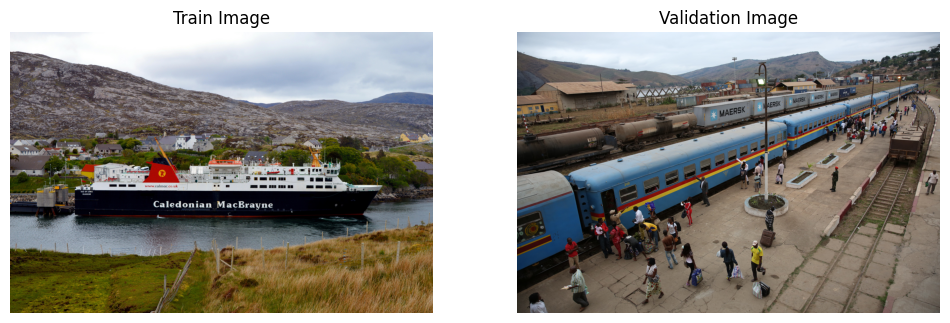

In [13]:
def fn():
    train_img_name = random.choice(os.listdir(train_path))
    valid_img_name = random.choice(os.listdir(valid_path))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
    ax[0].imshow(plt.imread(train_path+train_img_name))
    ax[0].axis("off")
    ax[0].set_title("Train Image")
    ax[1].imshow(plt.imread(valid_path+valid_img_name))
    ax[1].axis("off")
    ax[1].set_title("Validation Image")
    plt.show()

fn()

### **Data Preparation Pipeline**

In [18]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, lr_scale=4, transform=None):
        """
        Args:
            hr_dir (str): Directory with HR images.
            lr_scale (int): Downscaling factor for generating LR images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        super(DIV2KDataset, self).__init__()
        self.hr_dir = hr_dir
        self.hr_images = sorted([
            os.path.join(hr_dir, file) 
            for file in os.listdir(hr_dir) 
            if file.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.lr_scale = lr_scale

        # If a transform is provided, use it; otherwise, use a default set of augmentations.
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.hr_images)
    
    def __getitem__(self, idx):
        # Load HR image and convert to RGB
        hr_path = self.hr_images[idx]
        hr_image = Image.open(hr_path).convert('RGB')
        
        # Apply transformations to HR image
        hr_tensor = self.transform(hr_image)  # Tensor shape: [C, H, W]
        
        # Generate LR image by downsampling using bicubic interpolation
        # Convert tensor back to PIL image for resizing
        hr_pil = transforms.ToPILImage()(hr_tensor)
        C, H, W = hr_tensor.shape
        lr_w, lr_h = W // self.lr_scale, H // self.lr_scale
        lr_pil = hr_pil.resize((lr_w, lr_h), Image.BICUBIC)
        lr_tensor = transforms.ToTensor()(lr_pil)
        
        return {'lr': lr_tensor, 'hr': hr_tensor}

# Example usage:
if __name__ == '__main__':
    # Assuming 'path_to_div2k_hr' is the directory containing HR images from DIV2K.
    path_to_div2k_hr = train_path
    dataset = DIV2KDataset(hr_dir=path_to_div2k_hr, lr_scale=4)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

    # Fetch one batch and inspect shapes
    for batch in dataloader:
        print("LR batch shape:", batch['lr'].shape)  # Expected: [B, C, H/lr_scale, W/lr_scale]
        print("HR batch shape:", batch['hr'].shape)  # Expected: [B, C, H, W]
        break


In [19]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Diffusion Process Components**

In [20]:
import torch
import torch.nn as nn
import math

class DiffusionProcess:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        """
        Initializes the diffusion process.
        Args:
            T (int): Number of diffusion timesteps.
            beta_start (float): Starting value for the beta schedule.
            beta_end (float): Ending value for the beta schedule.
            device (str): Device to run the computations ('cuda' or 'cpu').
        """
        self.T = T
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, T, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)
    
    def get_index_from_list(self, vals, t, x_shape):
        """
        Retrieves the appropriate scalar for each sample in the batch given timestep t.
        Args:
            vals (torch.Tensor): Tensor of shape [T] containing values for each timestep.
            t (torch.Tensor): Tensor of shape [batch_size] containing timestep indices.
            x_shape (tuple): Shape of the target tensor (for proper broadcasting).
        Returns:
            torch.Tensor: A tensor of shape [batch_size, 1, 1, 1] (if image) for broadcasting.
        """
        batch_size = t.shape[0]
        out = vals[t].view(batch_size, *((1,)*(len(x_shape)-1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        """
        Forward diffusion process: q(x_t|x_0)
        x_t = sqrt(alpha_bar_t)*x_0 + sqrt(1 - alpha_bar_t)*noise
        
        Args:
            x_start (torch.Tensor): The original high-resolution image tensor.
            t (torch.Tensor): Timestep tensor of shape [batch_size].
            noise (torch.Tensor, optional): Pre-specified noise. If None, noise is sampled.
        Returns:
            torch.Tensor: The noisy image at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar_t = self.get_index_from_list(self.sqrt_alpha_bars, t, x_start.shape)
        sqrt_one_minus_alpha_bar_t = self.get_index_from_list(self.sqrt_one_minus_alpha_bars, t, x_start.shape)
        return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise
    
    @staticmethod
    def get_timestep_embedding(timesteps, embedding_dim):
        """
        Generates sinusoidal timestep embeddings.
        Args:
            timesteps (torch.Tensor): 1-D tensor of N indices, one per batch element.
            embedding_dim (int): Dimension of the embedding.
        Returns:
            torch.Tensor: Embeddings of shape [batch_size, embedding_dim].
        """
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad if embedding_dim is odd
            emb = torch.cat([emb, torch.zeros(timesteps.size(0), 1, device=emb.device)], dim=1)
        return emb

    def p_sample(self, model, x, t, lr):
        """
        Reverse diffusion process for one timestep.
        Predicts the noise using the model and computes x_{t-1} based on the DDPM formulation.
        
        Args:
            model (nn.Module): The denoising model (conditional on LR) predicting noise.
            x (torch.Tensor): The current image tensor at timestep t.
            t (torch.Tensor): Timestep tensor of shape [batch_size].
            lr (torch.Tensor): Low-resolution image tensor used for conditioning.
        Returns:
            torch.Tensor: The image tensor at timestep t-1.
        """
        # Predict noise using the model
        predicted_noise = model(x, t, lr)
        
        # Retrieve schedule values for current timesteps
        beta_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alpha_bar_t = self.get_index_from_list(self.sqrt_one_minus_alpha_bars, t, x.shape)
        sqrt_recip_alphas = 1.0 / torch.sqrt(self.get_index_from_list(self.alphas, t, x.shape))
        
        # Compute the mean following DDPM reverse process:
        # mu = 1/sqrt(alpha_t) * (x - (beta_t/sqrt(1 - alpha_bar_t)) * predicted_noise)
        model_mean = sqrt_recip_alphas * (x - beta_t / sqrt_one_minus_alpha_bar_t * predicted_noise)
        
        # For t > 0, add noise; for t == 0, return the mean
        noise = torch.randn_like(x) if t[0] > 0 else torch.zeros_like(x)
        sigma_t = torch.sqrt(beta_t)
        x_prev = model_mean + sigma_t * noise
        return x_prev

    def sample(self, model, lr, shape):
        """
        Generates a high-resolution image from noise, conditioned on an LR image.
        Iteratively applies p_sample for each timestep.
        
        Args:
            model (nn.Module): The denoising model (conditional on LR).
            lr (torch.Tensor): The low-resolution conditioning image.
            shape (tuple): The shape of the output image (batch_size, C, H, W).
        Returns:
            torch.Tensor: The generated high-resolution image.
        """
        x = torch.randn(shape, device=self.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.full((shape[0],), t, dtype=torch.long, device=self.device)
            x = self.p_sample(model, x, t_tensor, lr)
        return x

# Example usage:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    diffusion = DiffusionProcess(T=1000, device=device)
    
    # Dummy high-resolution image batch of shape [batch_size, C, H, W]
    x_start = torch.randn(4, 3, 64, 64, device=device)
    # Random timesteps for each image in the batch
    t = torch.randint(0, diffusion.T, (4,), device=device)
    
    # Forward diffusion: add noise to the original images
    x_t = diffusion.q_sample(x_start, t)
    print("Noisy image shape:", x_t.shape)
    
    # Note: p_sample and sample require a model (denoising network) which will be implemented next.


Noisy image shape: torch.Size([4, 3, 64, 64])


In [21]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Denoising Network Architecture (Conditional Generator)**

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dim, out_channels)
        self.activation = nn.ReLU(inplace=True)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, t_emb):
        # x: (batch, channels, H, W)
        out = self.activation(self.conv1(x))
        # Process time embedding and add to feature map
        t_emb_processed = self.activation(self.time_mlp(t_emb)).unsqueeze(-1).unsqueeze(-1)
        out = out + t_emb_processed
        out = self.activation(self.conv2(out))
        return out + self.residual_conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, cond_channels=3, base_channels=64, time_embedding_dim=128):
        """
        Args:
            in_channels (int): Number of channels in the noisy HR image.
            cond_channels (int): Number of channels in the LR conditioning image.
            base_channels (int): Base number of feature channels.
            time_embedding_dim (int): Dimension of the timestep embedding.
        """
        super().__init__()
        # Process the LR conditioning image
        self.lr_processor = nn.Sequential(
            nn.Conv2d(cond_channels, base_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Time embedding MLP: expects a tensor of shape (batch, 1)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim)
        )
        
        # Encoder: concatenate LR features with noisy HR input
        self.enc1 = ResidualBlock(in_channels + base_channels, base_channels, time_embedding_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(base_channels, base_channels * 2, time_embedding_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, time_embedding_dim)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(base_channels * 4, base_channels * 8, time_embedding_dim)
        
        # Decoder with skip connections
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(base_channels * 8, base_channels * 4, time_embedding_dim)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(base_channels * 4, base_channels * 2, time_embedding_dim)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(base_channels * 2, base_channels, time_embedding_dim)
        
        # Final layer to predict noise residual
        self.out_conv = nn.Conv2d(base_channels, in_channels, kernel_size=1)
    
    def forward(self, x, t, lr):
        """
        Args:
            x (torch.Tensor): Noisy HR image, shape [B, in_channels, H, W].
            t (torch.Tensor): Timestep tensor, shape [B].
            lr (torch.Tensor): LR conditioning image, shape [B, cond_channels, H, W].
        Returns:
            torch.Tensor: Predicted noise residual with shape [B, in_channels, H, W].
        """
        batch_size = x.shape[0]
        # Process timestep: reshape to [B, 1] then embed
        t = t.float().unsqueeze(1)
        t_emb = self.time_mlp(t)  # Shape: [B, time_embedding_dim]
        
        # Process LR image and concatenate with noisy HR image
        lr_features = self.lr_processor(lr)  # Shape: [B, base_channels, H, W]
        x = torch.cat([x, lr_features], dim=1)  # Shape: [B, in_channels + base_channels, H, W]
        
        # Encoder path
        enc1 = self.enc1(x, t_emb)         # [B, base_channels, H, W]
        enc1_pool = self.pool1(enc1)         # [B, base_channels, H/2, W/2]
        enc2 = self.enc2(enc1_pool, t_emb)   # [B, base_channels*2, H/2, W/2]
        enc2_pool = self.pool2(enc2)         # [B, base_channels*2, H/4, W/4]
        enc3 = self.enc3(enc2_pool, t_emb)   # [B, base_channels*4, H/4, W/4]
        enc3_pool = self.pool3(enc3)         # [B, base_channels*4, H/8, W/8]
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3_pool, t_emb)  # [B, base_channels*8, H/8, W/8]
        
        # Decoder path with upsampling and skip connections
        up3 = self.up3(bottleneck)                     # [B, base_channels*4, H/4, W/4]
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1), t_emb)  # [B, base_channels*4, H/4, W/4]
        up2 = self.up2(dec3)                           # [B, base_channels*2, H/2, W/2]
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1), t_emb)  # [B, base_channels*2, H/2, W/2]
        up1 = self.up1(dec2)                           # [B, base_channels, H, W]
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1), t_emb)  # [B, base_channels, H, W]
        
        # Output noise prediction
        out = self.out_conv(dec1)
        return out

# Example usage:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ConditionalUNet().to(device)
    
    # Dummy inputs:
    x = torch.randn(4, 3, 64, 64, device=device)   # Noisy HR image
    t = torch.randint(0, 1000, (4,), device=device)  # Random timesteps
    lr = torch.randn(4, 3, 64, 64, device=device)   # LR conditioning image (assumed pre-upsampled to HR size)
    
    output = model(x, t, lr)
    print("Output shape:", output.shape)  # Expected: [4, 3, 64, 64]

Output shape: torch.Size([4, 3, 64, 64])


In [23]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Adversarial Component**

In [24]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        """
        Patch-based discriminator similar to SRGAN discriminator.
        Args:
            in_channels (int): Number of channels in the input image.
            base_channels (int): Base number of feature maps.
        """
        super(PatchDiscriminator, self).__init__()
        self.net = nn.Sequential(
            # First layer: no batch norm
            nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsampling blocks
            nn.Conv2d(base_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final conv layer outputs a patch map of scores
            nn.Conv2d(base_channels * 4, 1, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.net(x)

def discriminator_hinge_loss(real_scores, fake_scores):
    """
    Computes the discriminator hinge loss.
    For real images: loss = ReLU(1 - D(x))
    For fake images: loss = ReLU(1 + D(G(z)))
    """
    loss_real = torch.mean(F.relu(1.0 - real_scores))
    loss_fake = torch.mean(F.relu(1.0 + fake_scores))
    return loss_real + loss_fake

def generator_hinge_loss(fake_scores):
    """
    Computes the generator hinge loss:
    loss = -mean(D(G(z)))
    """
    return -torch.mean(fake_scores)

# Example usage:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    discriminator = PatchDiscriminator().to(device)
    
    # Dummy data for testing:
    # Assume HR images of shape [batch_size, 3, 64, 64]
    real_images = torch.randn(4, 3, 64, 64, device=device)
    fake_images = torch.randn(4, 3, 64, 64, device=device)
    
    # Compute discriminator outputs
    real_scores = discriminator(real_images)
    fake_scores = discriminator(fake_images)
    
    # Calculate losses
    d_loss = discriminator_hinge_loss(real_scores, fake_scores)
    g_loss = generator_hinge_loss(fake_scores)
    
    print("Discriminator loss:", d_loss.item())
    print("Generator loss:", g_loss.item())


Discriminator loss: 2.0052385330200195
Generator loss: -0.18358011543750763


In [25]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Loss Functions**

In [26]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35, use_bn=False):
        """
        VGG feature extractor to compute perceptual loss.
        Args:
            feature_layer (int): Index of the layer up to which features are extracted.
            use_bn (bool): Whether to use VGG with batch normalization.
        """
        super(VGGFeatureExtractor, self).__init__()
        if use_bn:
            vgg19 = models.vgg19_bn(pretrained=True)
        else:
            vgg19 = models.vgg19(pretrained=True)
        # Extract features up to the specified layer.
        self.features = nn.Sequential(*list(vgg19.features.children())[:feature_layer+1])
        # Freeze VGG parameters
        for param in self.features.parameters():
            param.requires_grad = False
        self.features.eval()  # set to evaluation mode

    def forward(self, x):
        return self.features(x)

class SRDDPMLosses(nn.Module):
    def __init__(self, reconstruction_weight=1.0, perceptual_weight=1.0, diffusion_weight=1.0):
        """
        Combines the diffusion loss, reconstruction loss, and perceptual loss.
        Args:
            reconstruction_weight (float): Weight for the reconstruction (L1) loss.
            perceptual_weight (float): Weight for the perceptual loss.
            diffusion_weight (float): Weight for the diffusion (MSE) loss.
        """
        super(SRDDPMLosses, self).__init__()
        self.reconstruction_loss_fn = nn.L1Loss()
        self.diffusion_loss_fn = nn.MSELoss()
        self.vgg_extractor = VGGFeatureExtractor(feature_layer=35)  # Extract features from an intermediate layer
        self.reconstruction_weight = reconstruction_weight
        self.perceptual_weight = perceptual_weight
        self.diffusion_weight = diffusion_weight

    def forward(self, predicted_noise, true_noise, generated_hr, ground_truth_hr):
        """
        Computes the combined loss.
        Args:
            predicted_noise (torch.Tensor): Noise predicted by the model (from the reverse process).
            true_noise (torch.Tensor): Ground truth noise used in the forward diffusion.
            generated_hr (torch.Tensor): Generated high-resolution image.
            ground_truth_hr (torch.Tensor): Ground truth high-resolution image.
        Returns:
            total_loss (torch.Tensor): The weighted sum of diffusion, reconstruction, and perceptual losses.
            loss_dict (dict): A dictionary with individual loss components.
        """
        # Diffusion Loss: MSE between predicted and true noise
        diffusion_loss = self.diffusion_loss_fn(predicted_noise, true_noise)
        
        # Reconstruction Loss: L1 loss between generated HR and ground truth HR
        recon_loss = self.reconstruction_loss_fn(generated_hr, ground_truth_hr)
        
        # Perceptual Loss: Use VGG features to compare generated and ground truth images.
        # Normalize images using ImageNet statistics.
        normalization_mean = torch.tensor([0.485, 0.456, 0.406], device=ground_truth_hr.device).view(1, 3, 1, 1)
        normalization_std = torch.tensor([0.229, 0.224, 0.225], device=ground_truth_hr.device).view(1, 3, 1, 1)
        gt_norm = (ground_truth_hr - normalization_mean) / normalization_std
        gen_norm = (generated_hr - normalization_mean) / normalization_std
        
        # Extract VGG features (detach to ensure VGG remains fixed)
        vgg_features_gt = self.vgg_extractor(gt_norm).detach()
        vgg_features_gen = self.vgg_extractor(gen_norm)
        perceptual_loss = self.diffusion_loss_fn(vgg_features_gen, vgg_features_gt)
        
        # Combine losses with their respective weights
        total_loss = (self.diffusion_weight * diffusion_loss +
                      self.reconstruction_weight * recon_loss +
                      self.perceptual_weight * perceptual_loss)
        
        loss_dict = {
            'diffusion_loss': diffusion_loss,
            'recon_loss': recon_loss,
            'perceptual_loss': perceptual_loss
        }
        return total_loss, loss_dict

# Example usage:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Create dummy inputs for testing the loss functions
    batch_size = 4
    # Dummy noise predictions and ground truth noise (for diffusion loss)
    predicted_noise = torch.randn(batch_size, 3, 64, 64, device=device)
    true_noise = torch.randn(batch_size, 3, 64, 64, device=device)
    # Dummy generated HR image and ground truth HR image (for reconstruction and perceptual loss)
    generated_hr = torch.randn(batch_size, 3, 64, 64, device=device)
    ground_truth_hr = torch.randn(batch_size, 3, 64, 64, device=device)
    
    # Initialize the loss module with default weights
    loss_module = SRDDPMLosses().to(device)
    total_loss, loss_dict = loss_module(predicted_noise, true_noise, generated_hr, ground_truth_hr)
    
    print("Total Loss:", total_loss.item())
    print("Individual Losses:", {k: v.item() for k, v in loss_dict.items()})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 186MB/s] 


Total Loss: 3.6376090049743652
Individual Losses: {'diffusion_loss': 1.9908794164657593, 'recon_loss': 1.1283234357833862, 'perceptual_loss': 0.5184060335159302}


In [27]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Training Procedure**

In [29]:
# Assume the following classes have been defined as implemented above:
# - DIV2KDataset
# - ConditionalUNet
# - DiffusionProcess
# - PatchDiscriminator
# - SRDDPMLosses

def save_checkpoint(generator, discriminator, epoch, stage, checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'srddpm_stage{stage}_epoch{epoch}.pth')
    checkpoint = {'generator_state_dict': generator.state_dict(), 'epoch': epoch}
    if discriminator is not None:
        checkpoint['discriminator_state_dict'] = discriminator.state_dict()
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def train_diffusion_stage(generator, diffusion, dataloader, optimizer, device, epoch, total_epochs):
    generator.train()
    running_loss = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)
        batch_size = hr.shape[0]
        # Sample random timesteps for each image
        t = torch.randint(0, diffusion.T, (batch_size,), device=device)
        # Sample noise and add it to HR image using the forward diffusion process
        noise = torch.randn_like(hr)
        x_noisy = diffusion.q_sample(hr, t, noise=noise)
        # Predict noise using the generator conditioned on lr
        predicted_noise = generator(x_noisy, t, lr)
        # Compute diffusion loss (MSE between predicted and true noise)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        diffusion_loss.backward()
        optimizer.step()
        running_loss += diffusion_loss.item() * batch_size
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Diffusion Stage Epoch [{epoch}/{total_epochs}] - Loss: {epoch_loss:.4f}")
    return epoch_loss

def train_adversarial_stage(generator, discriminator, diffusion, dataloader, g_optimizer, d_optimizer, loss_module, device, epoch, total_epochs):
    generator.train()
    discriminator.train()
    running_g_loss = 0.0
    running_d_loss = 0.0
    for batch in dataloader:
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)
        batch_size = hr.shape[0]
        t = torch.randint(0, diffusion.T, (batch_size,), device=device)
        noise = torch.randn_like(hr)
        x_noisy = diffusion.q_sample(hr, t, noise=noise)
        
        # Generator forward pass: predict noise and compute generated HR image
        predicted_noise = generator(x_noisy, t, lr)
        sqrt_alpha_bar_t = diffusion.get_index_from_list(diffusion.sqrt_alpha_bars, t, hr.shape)
        sqrt_one_minus_alpha_bar_t = diffusion.get_index_from_list(diffusion.sqrt_one_minus_alpha_bars, t, hr.shape)
        # Recover generated HR image using a single reverse diffusion step approximation
        generated_hr = (x_noisy - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t
        
        # Generator adversarial loss: aim to fool the discriminator
        fake_scores = discriminator(generated_hr)
        g_adv_loss = -torch.mean(fake_scores)
        
        # Compute combined loss (diffusion, reconstruction, perceptual)
        total_loss, loss_dict = loss_module(predicted_noise, noise, generated_hr, hr)
        # Total generator loss: combination of losses (weights can be adjusted as needed)
        g_loss = total_loss + g_adv_loss
        
        g_optimizer.zero_grad()
        g_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        # Discriminator training: compute hinge loss
        real_scores = discriminator(hr)
        fake_scores = discriminator(generated_hr.detach())
        d_loss = torch.mean(F.relu(1.0 - real_scores)) + torch.mean(F.relu(1.0 + fake_scores))
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        running_g_loss += g_loss.item() * batch_size
        running_d_loss += d_loss.item() * batch_size
        
    epoch_g_loss = running_g_loss / len(dataloader.dataset)
    epoch_d_loss = running_d_loss / len(dataloader.dataset)
    print(f"Adversarial Stage Epoch [{epoch}/{total_epochs}] - Generator Loss: {epoch_g_loss:.4f}, Discriminator Loss: {epoch_d_loss:.4f}")
    return epoch_g_loss, epoch_d_loss

def main_training(generator, discriminator, diffusion, train_loader, device, diffusion_epochs=5, adversarial_epochs=5):
    # Stage 1: Diffusion training only.
    print("Starting Stage 1: Diffusion Training")
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
    
    for epoch in range(1, diffusion_epochs + 1):
        train_diffusion_stage(generator, diffusion, train_loader, g_optimizer, device, epoch, diffusion_epochs)
        # Save checkpoint (only generator is used in stage 1)
        save_checkpoint(generator, None, epoch, stage=1)
    
    # Stage 2: Adversarial (fine-tuning) training.
    print("Starting Stage 2: Adversarial Training")
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-5)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5)
    loss_module = SRDDPMLosses()  # Using default loss weights
    
    for epoch in range(1, adversarial_epochs + 1):
        train_adversarial_stage(generator, discriminator, diffusion, train_loader, g_optimizer, d_optimizer, loss_module, device, epoch, adversarial_epochs)
        # Save checkpoint for both generator and discriminator
        save_checkpoint(generator, discriminator, epoch, stage=2)

# Example usage:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Set the path to your DIV2K HR image directory.
    hr_dir = train_path  # Replace with the actual path
    dataset = DIV2KDataset(hr_dir=hr_dir, lr_scale=4)
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
    
    # Instantiate models and the diffusion process.
    generator = ConditionalUNet().to(device)
    discriminator = PatchDiscriminator().to(device)
    diffusion = DiffusionProcess(T=1000, device=device)
    
    # Run the training procedure:
    main_training(generator, discriminator, diffusion, train_loader, device,
                  diffusion_epochs=5, adversarial_epochs=5)


In [30]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!
